In [1]:
import xarray as xr
import numpy as np
import json, boto3, io

from edc import setup_environment_variables

%matplotlib inline

setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_NAME`
* `SH_CLIENT_SECRET`
* `SH_INSTANCE_ID`
* `SH_CLIENT_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
------


## Configuration

In [2]:
bucket_name=%env AWS_BUCKET
request_id = '3c26bf5d-2c8c-47e4-bd32-e81414511f8c'

## Get Metadata

In [3]:
s3 = boto3.resource('s3')
bk = s3.Bucket(bucket_name)

userdata_obj = bk.Object(f'{request_id}/userdata.json')
userdata = json.load(userdata_obj.get()['Body'])

tiles = set([o.key.split('/')[1] for o in bk.objects.all().filter(Prefix=request_id) if not '.json' in o.key])

## Create xarray from datacube

In [4]:
dss = []
for t in tiles:
    arrs = {b: xr.open_rasterio(f's3://{bucket_name}/{request_id}/{t}/{b}.tif') for b in userdata['bands']}
    dss.append(xr.Dataset(arrs))
    break # Kernel dies with big data cubes...
ds = xr.combine_by_coords(dss)

ds = ds.rename({'band': 'time'})#, 'y': 'lat', 'x': 'lon'})
ds.coords['time'] = [np.datetime64(t) for t in userdata['time']]
ds

<xarray.Dataset>
Dimensions:  (time: 14, x: 2004, y: 2004)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-08T11:59:59.500000 ... 2018-11-15T23:59:59.500000
  * y        (y) float64 5.28e+06 5.28e+06 5.28e+06 ... 5.26e+06 5.26e+06
  * x        (x) float64 5.801e+05 5.802e+05 5.802e+05 ... 6.002e+05 6.002e+05
Data variables:
    B02      (time, y, x) uint16 ...
    B03      (time, y, x) uint16 ...
    B04      (time, y, x) uint16 ...
    B05      (time, y, x) uint16 ...
    B06      (time, y, x) uint16 ...
    B07      (time, y, x) uint16 ...
    B08      (time, y, x) uint16 ...
    B8A      (time, y, x) uint16 ...
    B11      (time, y, x) uint16 ...
    B12      (time, y, x) uint16 ...
    NDVI     (time, y, x) uint16 ...
    GNDVI    (time, y, x) uint16 ...
    BNDVI    (time, y, x) uint16 ...
    CVI      (time, y, x) float32 ...
    NDSI     (time, y, x) uint16 ...
    NDWI     (time, y, x) uint16 ...

## Visualize

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'CVI' (time: 14, y: 2004, x: 2004)>
[56224224 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-04-08T11:59:59.500000 ... 2018-11-15T23:59:59.500000
  * y        (y) float64 5.28e+06 5.28e+06 5.28e+06 ... 5.26e+06 5.26e+06
  * x        (x) float64 5.801e+05 5.802e+05 5.802e+05 ... 6.002e+05 6.002e+05
Attributes:
    transform:               (10.0, 0.0, 580140.0, 0.0, -10.0, 5280000.0)
    crs:                     +init=epsg:32633
    res:                     (10.0, 10.0)
    is_tiled:                1
    nodatavals:              (nan, nan, nan, nan, nan, nan, nan, nan, nan, na...
    scales:                  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....
    offsets:                 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

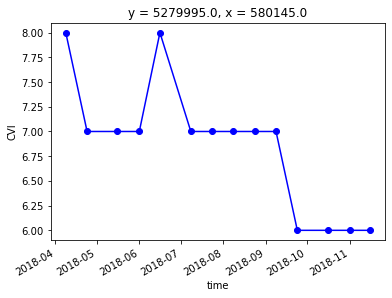

In [5]:
ds.isel(x=0, y=0).CVI.plot.line('b-o')

ds.CVI